In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

import utils
import visualize
from visualize import display_images
import libs.nets.model as modellib
from libs.nets.model import log

%matplotlib inline 

ROOT_DIR = os.getcwd()

In [2]:
import gen_cocodb
import train as coco

# Root directory of the project
ROOT_DIR = os.getcwd()
dataset_path = os.path.join(ROOT_DIR, 'data/coco')
config = coco.CocoConfig()
print(config.IMAGES_PER_GPU, config.NAME, config.NUM_CLASSES)

print('dataset_path: ', dataset_path)
dataset = gen_cocodb.CocoDataSet()
dataset.load_coco(dataset_path, "train", year="2014", auto_download=False)
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))


(2, 'coco', 81)
('dataset_path: ', '/home/tj/PycharmProjects/Instance-Segmetation/data/coco')
loading annotations into memory...
Done (t=9.85s)
creating index...
index created!
/home/tj/PycharmProjects/Instance-Segmetation/data/coco/train2014
Image Count: 82081
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      
 12. stop sign                                    

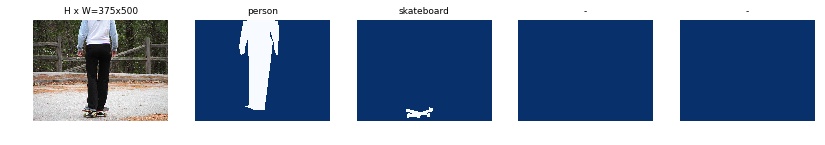

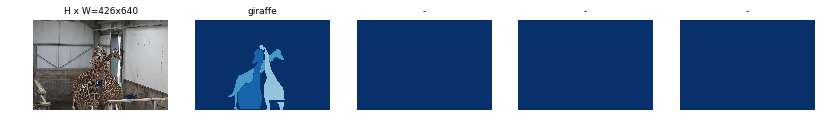

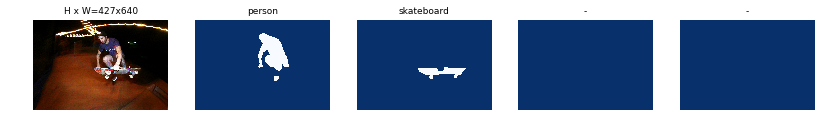

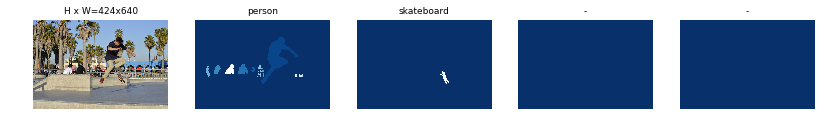

In [3]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image= dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Bounding Boxes

('image_id', 24287, 'http://cocodataset.org/#explore?id=37165')
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000
mask                     shape: (375, 500, 16)        min:    0.00000  max:    1.00000
class_ids                shape: (16,)                 min:    1.00000  max:   55.00000
bbox                     shape: (16, 4)               min:    0.00000  max:  475.00000


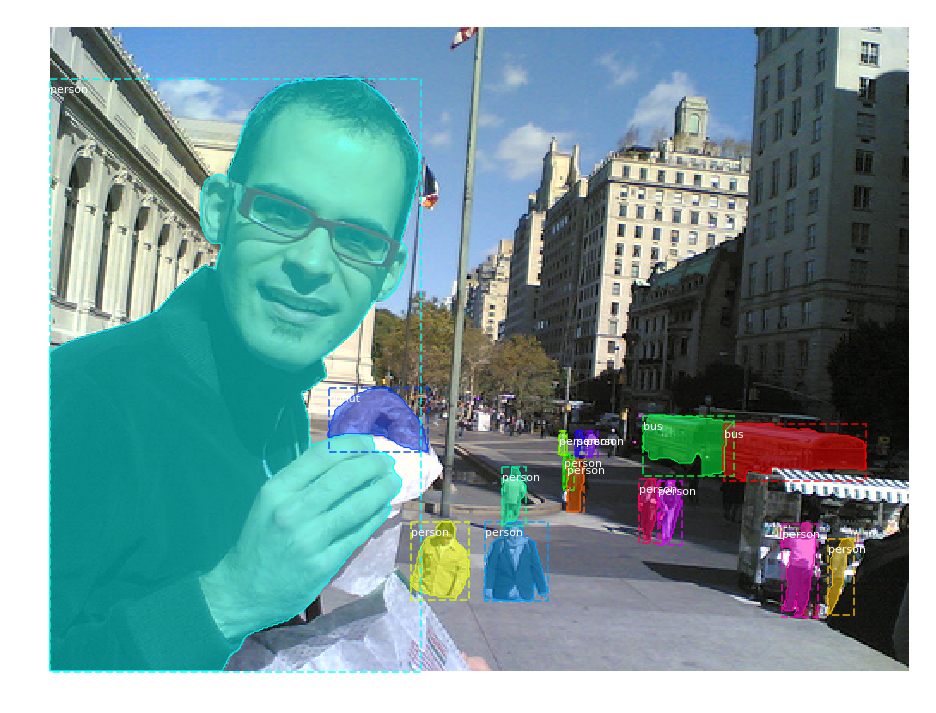

In [4]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

print("image_id", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Resize Images

/home/tj/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:576: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


('image_id', 79573, 'http://cocodataset.org/#explore?id=389190')
('Original_shape', (375, 500, 3))
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000
class_ids                shape: (1,)                  min:   26.00000  max:   26.00000
bbox                     shape: (1, 4)                min:  666.00000  max: 1012.00000


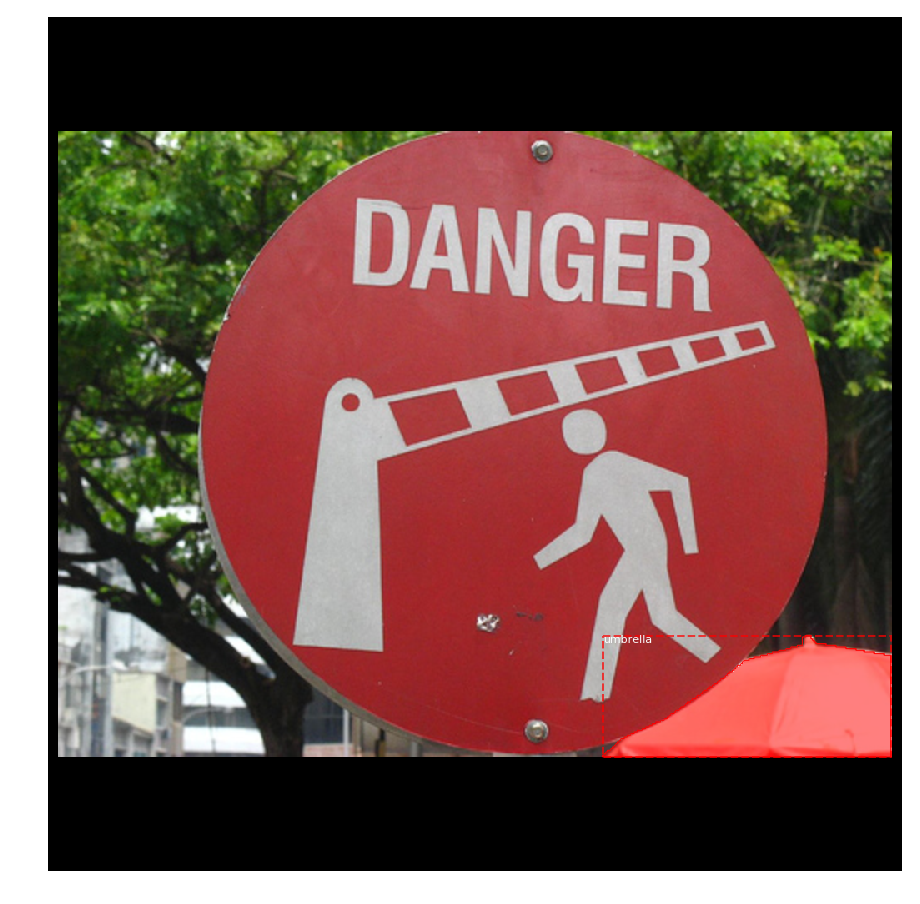

In [5]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding = gen_cocodb.resize_image(image, 
                                                   min_dim=config.IMAGE_MIN_DIM,
                                                   max_dim=config.IMAGE_MAX_DIM,
                                                   padding=config.IMAGE_PADDING)
mask = gen_cocodb.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

print("image_id", image_id, dataset.image_reference(image_id))
print("Original_shape", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Min Masks

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (89,)                 min:    1.00000  max: 62679.00000
class_ids                shape: (3,)                  min:    1.00000  max:   56.00000
bbox                     shape: (3, 4)                min:  192.00000  max:  832.00000
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000


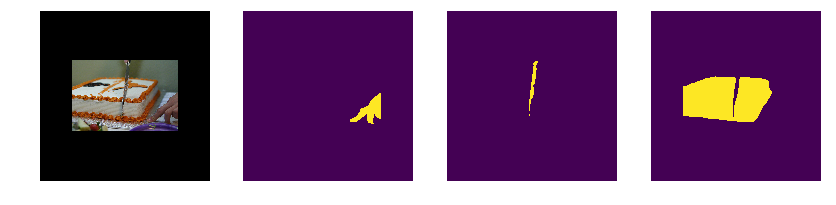

In [6]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = dataset.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

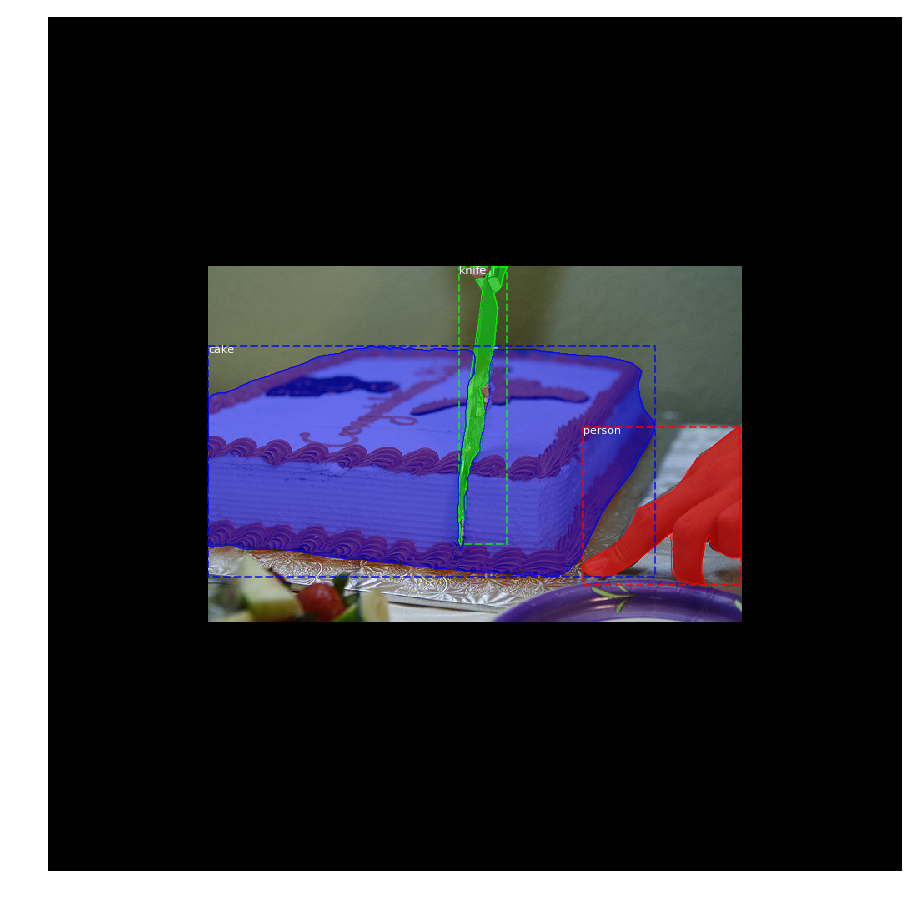

In [7]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 3)           min:    0.00000  max:    1.00000


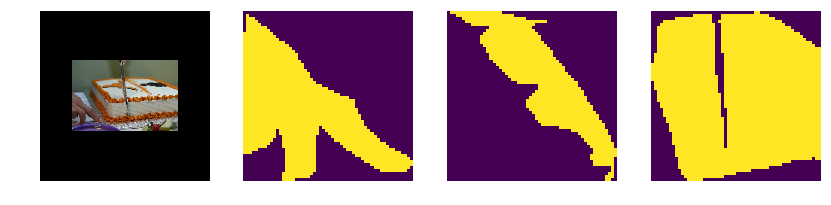

In [8]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = dataset.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

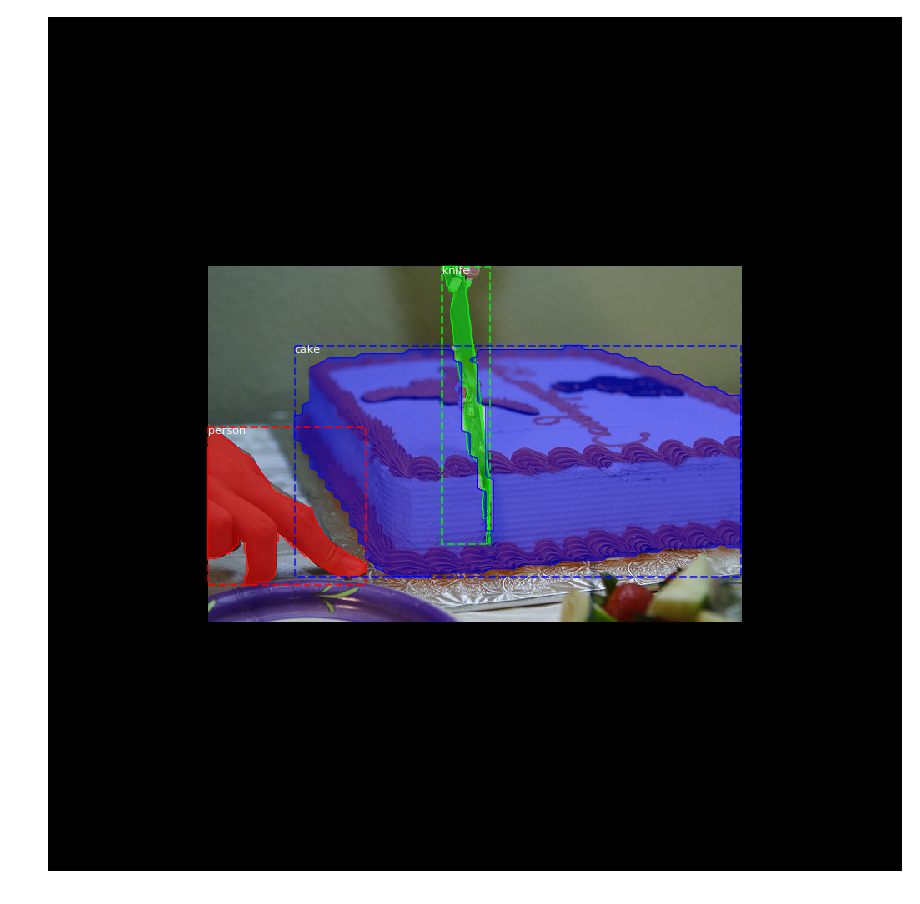

In [9]:
mask = gen_cocodb.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Anchors

In [10]:
# Generate Anchors
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

('Count: ', 261888)
('Scales: ', (32, 64, 128, 256, 512))
('ratios: ', [0.5, 1, 2])
('Anchors per Cell: ', 3)
('Levels: ', 5)
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


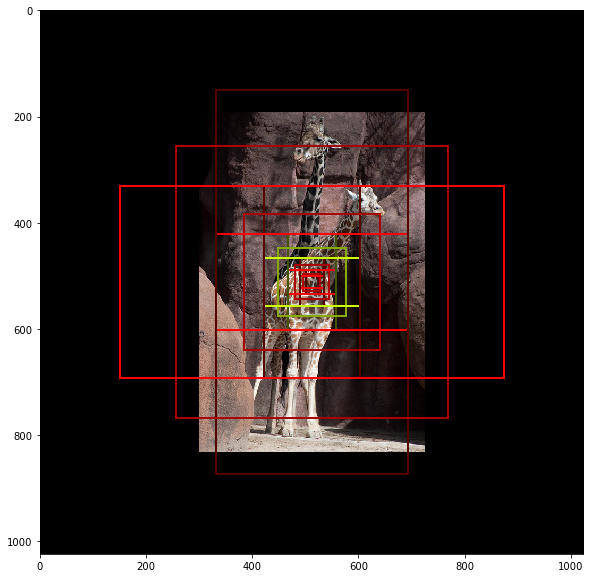

In [11]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = dataset.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

# Data Generator

In [12]:
# Create data generator
import test
random_rois = 2000
g = test.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [13]:
# Get Next Image
if random_rois:
    inputs, outputs = g
    print(len(inputs), len(outputs))
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois] = inputs
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = outputs
    
    print(mrcnn_class_ids.shape)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
    print(mrcnn_class_ids.shape)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks] = inputs


log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

(9, 3)
(4, 200, 1)
rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:   68.00000
mrcnn_bbox               shape: (4, 200, 81, 4)       min:   -3.30745  max:    3.30357
mrcnn_mask               shape: (4, 200, 28, 28, 81)  min:    0.00000  max:    1.00000
(4, 200, 1)
gt_class_ids             shape: (4, 100)              min:   -1.00000  max:   68.00000
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  832.00000
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (4, 256, 4)           min:   -7.07207  max:    6.18773
('image_id: ', 18263, 'http://cocodataset.org/#explore?id=433021')


mrcnn_class_ids          shape: (4, 200)              min:    0.00000  max:   68.00000
(4, 200)
anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (1, 4)                min:  387.00000  max:  621.00000
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 261632
mrcnn_class_ids          shape: (4, 200)              min:    0.00000  max:   68.00000
BG                     : 187
stop sign              : 13


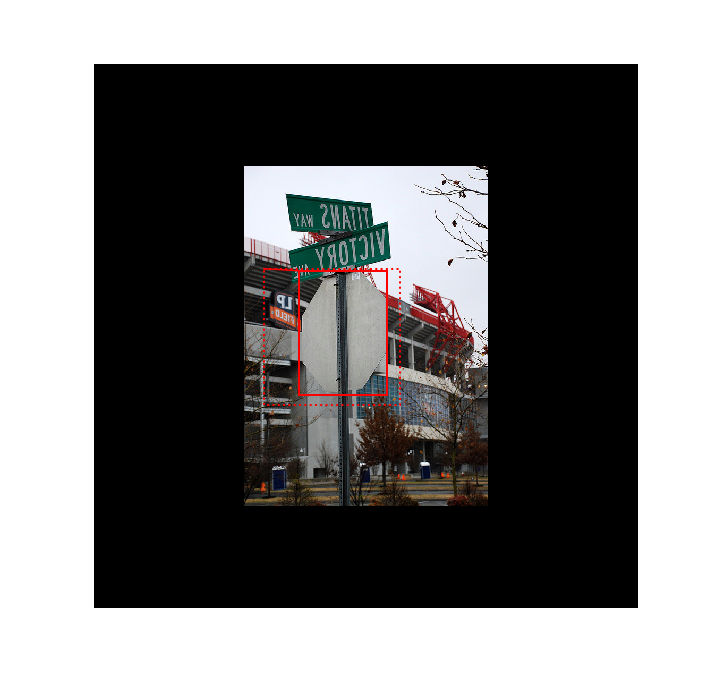

In [14]:
b = 0
log("mrcnn_class_ids", mrcnn_class_ids)
print(mrcnn_class_ids.shape)
# Restore original image (reverse normalization)
sample_image = gen_cocodb.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
log("mrcnn_class_ids", mrcnn_class_ids)
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

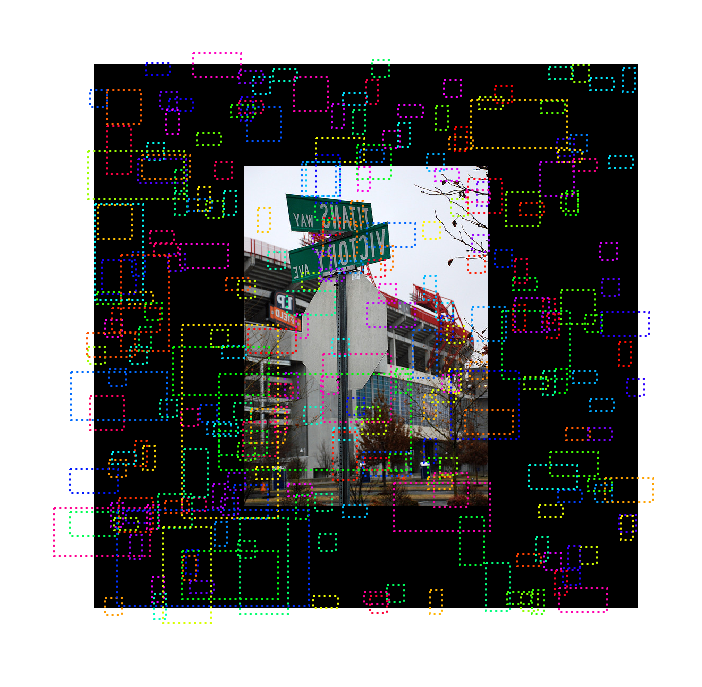

In [15]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

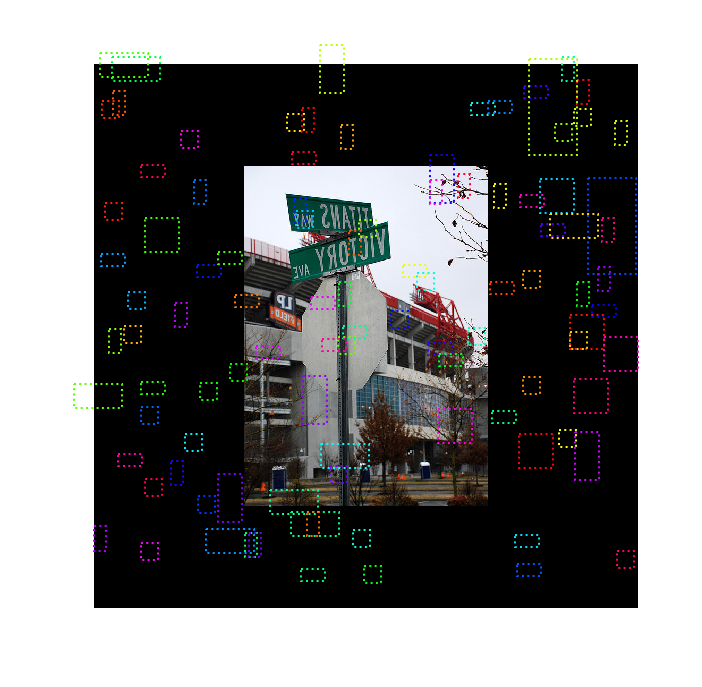

In [16]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

((4, 200, 4), (200, 4), (4, 200, 81, 4), (4, 200), (4, 200, 4))
0.065
('Positive ROIs: ', 13)
('Negative ROIs: ', 187)
Positive Ratio: 0.07
Unique ROIs: 200 out of 200


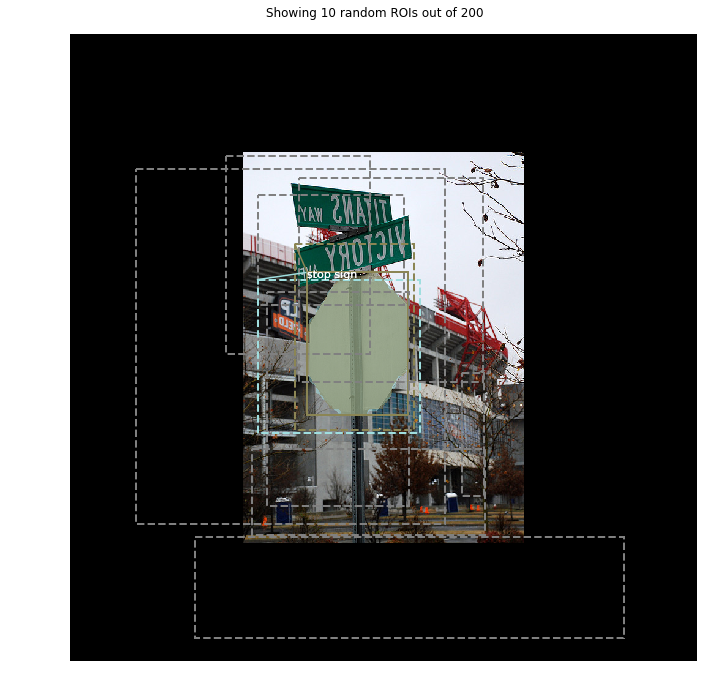

In [17]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    print(rois.shape, bbox_specific.shape, mrcnn_bbox.shape, mrcnn_class_ids.shape, rois.shape)
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

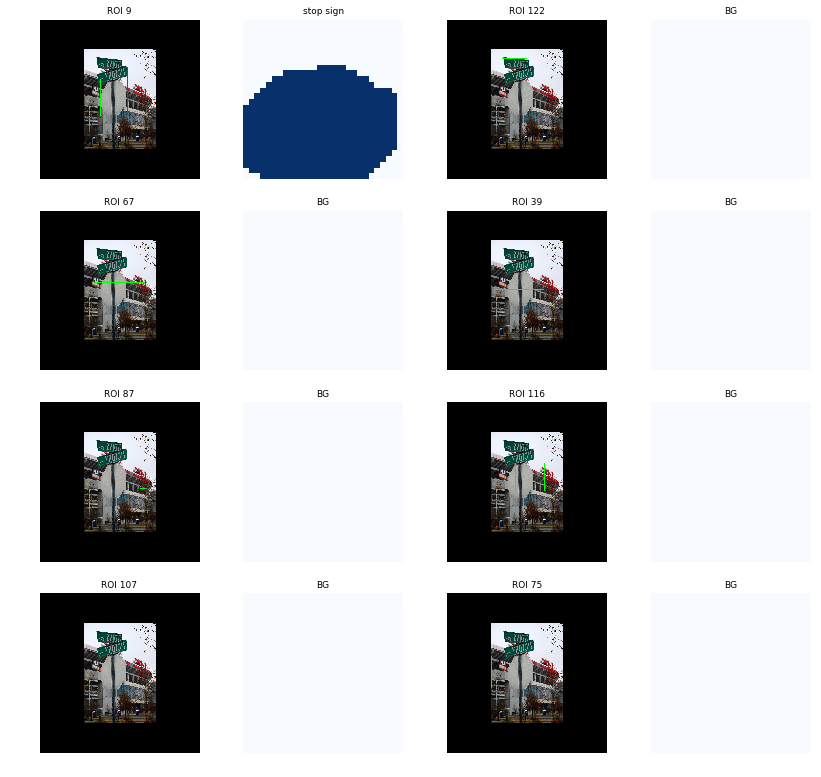

In [18]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [19]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    inputs, outputs = test.data_generator(
    dataset, config, shuffle=True, random_rois=10000, 
    batch_size=1, detection_targets=True)
    
    total = 0
    for i in range(limit):
        ids = outputs[0]
        print(ids.shape)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois / float(ids.shape[1])))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))


(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
(1, 200, 1)
   66  0.33
Average percent: 0.00
